Image shape: (512, 512, 104)
Data type: float64; Min: -1024.0; Max: 1444.0
Image2 shape: (512, 512, 424)
Data2 type: float64; Min: -1024.0; Max: 2526.0


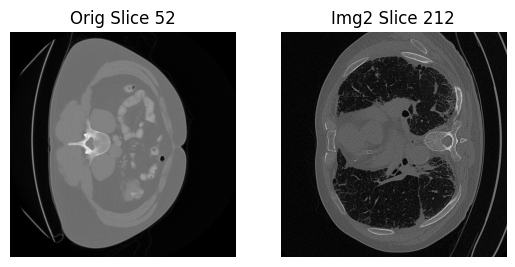

In [33]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .nii.gz file
file_path = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/example-1.nii.gz'
file_path2 = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/data/OSIC/imgs_20/33_0000.nii.gz'
# file_path2 = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/data/OSIC/gt_20/33.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()
print(f"Image shape: {data.shape}")
print(f"Data type: {data.dtype}; Min: {data.min()}; Max: {data.max()}")
try:
    img2 = nib.load(file_path2)
    data2 = img2.get_fdata()
    print(f"Image2 shape: {data2.shape}")
    print(f"Data2 type: {data2.dtype}; Min: {data2.min()}; Max: {data2.max()}")
except FileNotFoundError:
    pass

# Get the image data as a numpy array


# Display slices of the image
slice_index = data.shape[2] // 2  # Middle slice along the z-axis
# slice_index = 10
plt.Figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, slice_index], cmap='gray')
plt.title(f'Orig Slice {slice_index}')
plt.axis('off')
if 'data2' in locals():
    slice_index = data2.shape[-1] // 2
    plt.subplot(1, 2, 2)
    plt.imshow(data2[:, :, slice_index], cmap='gray')
    plt.title(f'Img2 Slice {slice_index}')
    plt.axis('off')
plt.show()

## Inference debugger

In [59]:
import os, sys
import copy
from tkinter import Tk, filedialog, messagebox

import fire
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.widgets import Button, TextBox
print('current dir:', os.getcwd())
if not os.getcwd().endswith('vista3d'):
    WORK_ROOT = os.path.dirname(os.getcwd()) #vista3d/
    os.chdir(WORK_ROOT)
    sys.path.insert(0,WORK_ROOT)
    
from functools import partial
import torch
import monai

from monai.data import decollate_batch, list_data_collate, partition_dataset
from scripts.infer_debug import InferClass
from scripts.utils.workflow_utils import get_point_label

from scripts.sliding_window import point_based_window_inferer, sliding_window_inference
from scripts.utils.trans_utils import VistaPostTransform, get_largest_connected_component_point


window_max = None
window_max = -200
window_min = -1024

# window_max = 1053.678477684517
# window_min = -963.8247715525971

inferer = InferClass(config_file=["configs/infer.yaml"])

if window_max is not None:
    inferer.infer_transforms.transforms[2].scaler.a_max = window_max
    inferer.infer_transforms.transforms[2].scaler.a_min = window_min

# file_path = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/example-1.nii.gz'
file_path = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/data/OSIC/imgs_20/33_0000.nii.gz'
gt_path = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/data/OSIC/gt_20/33.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()
print(f"Image shape: {data.shape}")
print(f"Data type: {data.dtype}; Min: {data.min()}; Max: {data.max()}")

gt = nib.load(gt_path).get_fdata()
print(f"GT type: {gt.dtype}; Min: {gt.min()}; Max: {gt.max()}")

current dir: /media/ssd1/zhangsheng/data/nnUNet/gavin_vista3d/vista3d
Current path: /media/ssd1/zhangsheng/data/nnUNet/gavin_vista3d/vista3d
Config file: ['configs/infer.yaml']
Override: {}
Args: {'config_file': ['configs/infer.yaml']}


/home/shengzhang/miniconda3/envs/vista3d/lib/python3.10/site-packages/monai/utils/dist.py:198: UserWarning: The torch.distributed is either unavailable and uninitiated when RankFilter is instantiated.
If torch.distributed is used, please ensure that the RankFilter() is called
after torch.distributed.init_process_group() in the script.

  warnings.warn(


Image shape: (512, 512, 424)
Data type: float64; Min: -1024.0; Max: 2526.0
GT type: float64; Min: 0.0; Max: 1.0


In [60]:
def infer_debug(
    self,
    image_file,
    label_prompt=None,
    save_mask=False,
):
    self.model.eval()
    if not isinstance(image_file, dict):
        image_file = {"image": image_file}

    # first transform: infer_transforms, load image, resample, normalize
    batch_data = self.infer_transforms(image_file) # torch.Size([1, 308, 308, 344]), float32, (0,1)
    if label_prompt is not None:
        batch_data["label_prompt"] = label_prompt
    batch_data = list_data_collate([batch_data])
    self.batch_data = batch_data
    
    # second transform: post_transforms, resize, normalize
    batch_data["image"] = batch_data["image"].to("cpu")
    batch_data["pred"] = batch_data["image"].clone()

    torch.cuda.empty_cache()
    batch_data_post = [
        self.post_transforms(i) for i in decollate_batch(batch_data)
    ]
    
    # Third transform: save_transforms, save the mask
    if save_mask:
        batch_data_save = [self.save_transforms(i) for i in batch_data_post]
    
        
    return batch_data, batch_data_post, batch_data_save
        
batch_data,  batch_data_post, batch_data_save= infer_debug(
    inferer,
    image_file=file_path,
    label_prompt=[1],
    save_mask=True,
)
print(f'batch_data shape: {batch_data["image"].shape}')
print(f'batch_data dtype: {batch_data["image"].dtype}')
print(f'batch_data value range: {(batch_data["image"].min(), batch_data["image"].max())}')
# # print(f'batch_data meta: {batch_data["image"].meta}')
# print(f'batch_data_post shape: {batch_data_post[0]["image"].shape}')
# print(f'batch_data_post dtype: {batch_data_post[0]["image"].dtype}')
# print(f'batch_data_post value range: {(batch_data_post[0]["image"].min(), batch_data_post[0]["image"].max())}')

# print(f'batch_data_save shape: {batch_data_save[0]["image"].shape}')
# print(f'batch_data_save dtype: {batch_data_save[0]["image"].dtype}')
# print(f'batch_data_save value range: {(batch_data_save[0]["image"].min(), batch_data_save[0]["image"].max())}')

batch_data shape: torch.Size([1, 1, 342, 342, 283])
batch_data dtype: torch.float32
batch_data value range: (metatensor(0.), metatensor(1.))


Text(0.5, 1.0, 'Slice 141')

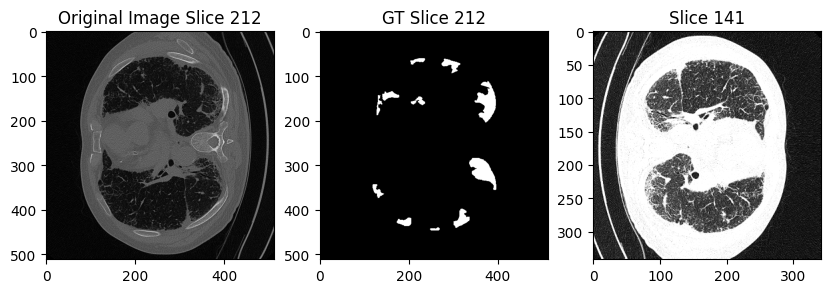

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
slice_index = data.shape[2] // 2
plt.imshow(data[:, :, slice_index], cmap='gray') #[512,512,104] -> 27,262,976
plt.title(f'Original Image Slice {slice_index}')
plt.subplot(1, 3, 2)
plt.imshow(gt[:, :, slice_index], cmap='gray') #[308, 308, 344] -> 32,633,216
plt.title(f'GT Slice {slice_index}')

slice_index_batch = batch_data["image"].shape[-1] // 2
plt.subplot(1, 3, 3)
plt.imshow(batch_data["image"][0, 0, :, :, slice_index_batch], cmap='gray') #[308, 308, 344] -> 32,633,216
# plt.imshow(batch_data_post[0]["image"][0, :, :, slice_index], cmap='gray') #[308, 308, 344] -> 32,633,216
plt.title(f'Slice {slice_index_batch}')
# plt.axis('off')


In [50]:
print(batch_data["image"][0,0].shape)
print(batch_data_post[0]["image"][0].shape)
torch.equal(batch_data["image"][0,0], batch_data_save[0]["image"][0])

torch.Size([342, 342, 283])
torch.Size([342, 342, 283])


True

### Inference Code

In [ ]:
def infer_wrapper(inputs, model, **kwargs):
    outputs = model(input_images=inputs, **kwargs)
    return outputs.transpose(1, 0)


model = inferer.model
model.eval()

def infer_debug(
    self,
    image_file,
    point=None,
    point_label=None,
    label_prompt=None,
    prompt_class=None,
    save_mask=False,
    point_start=0,
):
    self.model.eval()
    if not isinstance(image_file, dict):
        image_file = {"image": image_file}
    if self.batch_data is not None:
        batch_data = self.batch_data
    else:
        batch_data = self.infer_transforms(image_file) # torch.Size([1, 308, 308, 344]), float32, (0,1)
        if label_prompt is not None:
            batch_data["label_prompt"] = label_prompt
        batch_data = list_data_collate([batch_data])
        self.batch_data = batch_data
        # if point is None
        self.sliding_window_inferer = sliding_window_inference
    device_list_input = [self.device, self.device, "cpu"]
    device_list_output = [self.device, "cpu", "cpu"]

    for _device_in, _device_out in zip(device_list_input, device_list_output):
        with torch.cuda.amp.autocast(enabled=self.amp):
            batch_data["pred"] = self.sliding_window_inferer(
                inputs=batch_data["image"].to(_device_in),
                roi_size=self.patch_size,
                sw_batch_size=1,
                predictor=partial(infer_wrapper, model=self.model),
                mode="gaussian",
                overlap=0.625,
                progress=True,
                sw_device=self.device,
                device=_device_out,
                point_coords=(
                    torch.tensor(point).to(_device_in)
                    if point is not None
                    else None
                ),
                point_labels=(
                    torch.tensor(point_label).to(_device_in)
                    if point_label is not None
                    else None
                ),
                class_vector=(
                    torch.tensor(label_prompt).to(_device_in)
                    if label_prompt is not None
                    else None
                ),
                prompt_class=(
                    torch.tensor(prompt_class).to(_device_in)
                    if prompt_class is not None
                    else None
                ),
                prev_mask=(
                    torch.tensor(self.prev_mask).to(_device_in)
                    if self.prev_mask is not None
                    else None
                ),
            )

            if not hasattr(batch_data["pred"], "meta"):
                batch_data["pred"] = monai.data.MetaTensor(
                    batch_data["pred"],
                    affine=batch_data["image"].meta["affine"],
                    meta=batch_data["image"].meta,
                )
        self.prev_mask = batch_data["pred"]
        if label_prompt is None and point is not None:
            batch_data["pred"] = get_largest_connected_component_point(
                batch_data["pred"], point_coords=point, point_labels=point_label
            )
        batch_data["image"] = batch_data["image"].to("cpu")
        batch_data["pred"] = batch_data["pred"].to("cpu")
        torch.cuda.empty_cache()
        batch_data = [
            self.post_transforms(i) for i in decollate_batch(batch_data)
        ]
        if save_mask:
            batch_data = [self.save_transforms(i) for i in batch_data]

        finished = True
        if finished:
            break
        
    return batch_data[0]["pred"]

pred = infer_debug(
    inferer,
    image_file=file_path,
    label_prompt=[1],
    save_mask=False,
)
# Print the result for debugging
result = pred.numpy()
print("Inference result shape:", result.shape)
print(f"dtype: {result.dtype}; value range:{(result.min(),result.max())}")